### Project: 
Visualizing Differences in Brain Connectivity Between ASD and Control Subjects and a Basic Classifier Test
Hypothesis:
Average functional connectivity patterns (group mean connectivity matrices) differ between ASD and control individuals.

Analysis plan
- Compute and plot mean correlation matrices for ASD vs control (heatmaps).
- Run a simple standardized ML pipeline (StandardScaler → LogisticRegression with L2) with LOSO.
- Perform permutation test (500 permutations) to show whether accuracy > chance.

ABIDE Option B pipeline:
- Build FC features from rois_cc200 .1D files (CPAC / nofilt_noglobal expected)
- Compute group mean connectivity matrices (Fisher-z average -> back to r)
- Plot heatmaps (ASD mean, Control mean, Difference)
- Evaluate LogisticRegression with Leave-One-Group-Out (group = SITE_ID)
- Permutation test (n_perms = 500) to compute p-value

Python Scripts for data download from ABIDE preproc data:
- ASD data: python download_abide_preproc.py -a -d rois_cc200 -p cpac -s nofilt_noglobal -o C:\Users\Acct\Downloads\ABIDE\ASD_Males_5_30 -gt 5 -lt 30 -x M
- CONTROL data: python download_abide_preproc.py -c -d rois_cc200 -p cpac -s nofilt_noglobal -o C:\Users\Acct\Downloads\ABIDE\Control_Males_5_30 -gt 5 -lt 30 -x M
- Data downloading script download_abide_preproc.py is available on ABIDE website: https://fcon_1000.projects.nitrc.org/indi/abide/preprocessed.html

In [1]:
import os, glob, math, time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils import shuffle
import warnings
from joblib import Parallel, delayed
from matplotlib.lines import Line2D
import umap
from nilearn import datasets, plotting, image
import nibabel as nib
import numpy as np
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve, auc,
                             precision_recall_curve, average_precision_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             classification_report)

In [2]:
# Map data files for subject ID, diagnosis, and collection site
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_DIR = "data" # inside here there are subfolders "ASD" and "CONTROL"
roi_files = glob.glob(os.path.join(DATA_DIR, "**", "*rois_cc200*.1D"), recursive=True)
print(f"Found {len(roi_files)} .1D files")

records = []
for f in roi_files:
    basename = os.path.basename(f)  # e.g. "MaxMun_d_0051360_rois_cc200.1D"
    folder = os.path.basename(os.path.dirname(f))  # "ASD" or "CONTROL"
    
    # split filename by "_" to get site and subject ID
    parts = basename.split("_")
    site = "_".join(parts[:-3])     # everything except last three parts
    subject_id = parts[-3]          # the subject ID (like 0051360)
    
    records.append({
        "subject_id": subject_id,
        "diagnosis": folder,  # comes from folder name
        "site": site,
        "file_path": f})

pheno_simple = pd.DataFrame(records)
# pheno_simple.to_csv("pheno_simple.csv", index = False)
print("pheno_simple successfully saved to output.csv")
print(pheno_simple.head(2))

# Import MRI time series data, gnerate X (time series data), y (label), group (collection site)
ts_example = np.loadtxt(pheno_simple.iloc[0]["file_path"])
print("\nTime series shape:", ts_example.shape)
R = ts_example.shape[1]         # number of ROIs

# --- iterate pheno_simple rows and build features ---
X_list = []      # vectorized upper-triangle Fisher-z values - holds each subject’s connectivity features
y_list = []      # 1=ASD, 0=TDC, hold labels
groups = []      # SITE_ID per subject
included_subjects = []  # record of which subjects made it in

# For computing group mean Z matrices without storing all matrices: accumulate sums and counts
sumZ_asd = np.zeros((R, R), dtype=np.float64)
count_asd = 0
sumZ_tdc = np.zeros((R, R), dtype=np.float64)
count_tdc = 0
n_skipped_missing = 0

rows = pheno_simple.to_dict('records') # conver the df so it is easier to iterate
print(rows[0])

start_time = time.time()
for row in rows:
    fid = str(row["subject_id"]).strip()
    dx = row["diagnosis"]
    site = row["site"]
    path = row["file_path"]

    # --- map diagnosis into labels ---
    if dx == 'ASD':
        label = 1
    elif dx == 'CONTROL':
        label = 0
    else:
        continue # skip unknown dx codes

    # --- load ROI time series ---
    try:
        ts = np.loadtxt(path)  # shape usually (T, R)
    except Exception as e:
        print("Failed loading", path, e)
        continue

    if ts.ndim != 2:
        print("Skipping weird-shaped timeseries:", path)
        continue
    # if ts.shape[0] < ts.shape[1]:
    #     ts = ts.T
    T, Rcurr = ts.shape

    if Rcurr != R:
        print("Warning: ROI count mismatch for", path, "expected", R, "got", Rcurr)
        continue

    # --- correlation matrix ---
    # Compute connectivity
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        C = np.corrcoef(ts.T) # R x R Correlation across ROIs
    C = np.nan_to_num(C, nan=1e-10)  # replace NaNs with 0 correlation
    eps = 1e-7
    C = np.clip(C, -1 + eps, 1 - eps)  # avoid +/-1
    Z = np.arctanh(C)  # Fisher z transform

    # --- vectorize upper triangle ---
    iu = np.triu_indices(R, k=1)
    feat = Z[iu]

    # --- save subject-level data ---
    X_list.append(feat.astype(np.float32))
    y_list.append(label)
    groups.append(site)
    included_subjects.append(fid)

    # --- accumulate group averages ---
    if label == 1:
        sumZ_asd += Z
        count_asd += 1
    else:
        sumZ_tdc += Z
        count_tdc += 1

print(f"Loaded features for {len(X_list)} subjects (skipped {n_skipped_missing} missing). "
      f"Time: {time.time()-start_time:.1f}s")

X = np.vstack(X_list).astype(np.float32)
y = np.array(y_list, dtype=np.int32)
groups = np.array(groups)
print("Feature matrix shape:", X.shape, "Labels:", np.bincount(y))

Found 679 .1D files
pheno_simple successfully saved to output.csv
  subject_id diagnosis     site                               file_path
0    0051457       ASD  Caltech  data\ASD\Caltech_0051457_rois_cc200.1D
1    0051459       ASD  Caltech  data\ASD\Caltech_0051459_rois_cc200.1D

Time series shape: (146, 200)
{'subject_id': '0051457', 'diagnosis': 'ASD', 'site': 'Caltech', 'file_path': 'data\\ASD\\Caltech_0051457_rois_cc200.1D'}
Loaded features for 679 subjects (skipped 0 missing). Time: 5.5s
Feature matrix shape: (679, 19900) Labels: [360 319]


Explained variance (PC1+PC2): 27.08%


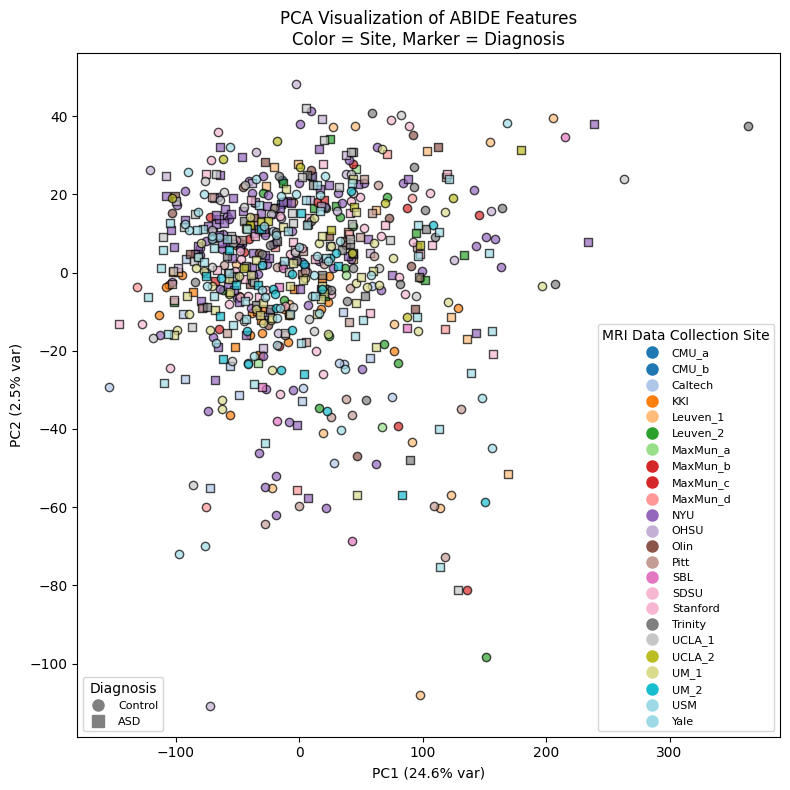

In [3]:
# --- PCA ---
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance (PC1+PC2): {pca.explained_variance_ratio_[:2].sum()*100:.2f}%")

# --- Visualization ---
plt.figure(figsize=(8,8))

# Define markers for ASD vs Control
markers = {0: 'o', 1: 's'}  # Control = circle, ASD = square
diagnosis_labels = {0: 'Control', 1: 'ASD'}

# Unique sites
sites = np.unique(groups)
colors = plt.get_cmap("tab20", len(sites))  # up to 20 distinct colors

# Plot points
for site_idx, site in enumerate(sites):
    for label in [0, 1]:
        mask = (groups == site) & (y == label)
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=[colors(site_idx)],
                    marker=markers[label],
                    edgecolor="k",
                    alpha=0.7)

# Legends
# Site legend (color)
site_legend = [Line2D([0], [0], marker='o', color=colors(i), linestyle='', markersize=8, label=f"{site}")
               for i, site in enumerate(sites)]
# Diagnosis legend (marker)
diagnosis_legend = [Line2D([0], [0], marker=markers[label], color='grey', linestyle='', markersize=8, label=diagnosis_labels[label])
                    for label in [0, 1]]

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA Visualization of ABIDE Features\nColor = Site, Marker = Diagnosis")

# Add legends separately
first_legend = plt.legend(handles=site_legend, title="MRI Data Collection Site", loc="lower right", fontsize=8)
plt.gca().add_artist(first_legend)
plt.legend(handles=diagnosis_legend, title="Diagnosis", loc="lower left", fontsize=8)

plt.tight_layout()
plt.show()

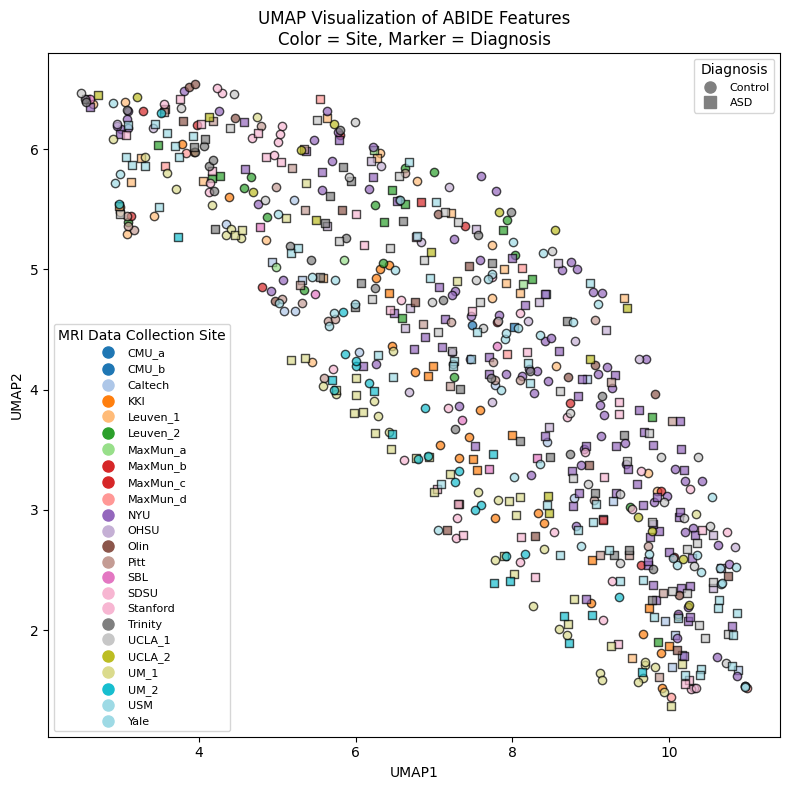

In [4]:
# --- UMAP ---
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="umap")
X_scaled = StandardScaler().fit_transform(X)

# Initialize UMAP
reducer = umap.UMAP(
    n_neighbors=15,   # typical value, can tune
    min_dist=0.1,     # typical value, can tune
    n_components=2,
    random_state=42, n_jobs=-1)
X_umap = reducer.fit_transform(X_scaled)

# --- Visualization ---
plt.figure(figsize=(8,8))

# Define markers for ASD vs Control
markers = {0: 'o', 1: 's'}  # Control = circle, ASD = square
diagnosis_labels = {0: 'Control', 1: 'ASD'}

# Unique sites
sites = np.unique(groups)
colors = plt.get_cmap("tab20", len(sites))  # up to 20 distinct colors

# Plot points
for site_idx, site in enumerate(sites):
    for label in [0, 1]:
        mask = (groups == site) & (y == label)
        plt.scatter(X_umap[mask, 0], X_umap[mask, 1],
                    c=[colors(site_idx)],
                    marker=markers[label],
                    edgecolor="k",
                    alpha=0.7)

# Legends
# Site legend (color)
site_legend = [Line2D([0], [0], marker='o', color=colors(i), linestyle='', markersize=8, label=f"{site}")
               for i, site in enumerate(sites)]
# Diagnosis legend (marker)
diagnosis_legend = [Line2D([0], [0], marker=markers[label], color='grey', linestyle='', markersize=8, label=diagnosis_labels[label])
                    for label in [0, 1]]

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP Visualization of ABIDE Features\nColor = Site, Marker = Diagnosis")

# Add legends separately
first_legend = plt.legend(handles=site_legend, title="MRI Data Collection Site", loc="lower left", fontsize=8)
plt.gca().add_artist(first_legend)
plt.legend(handles=diagnosis_legend, title="Diagnosis", loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()

Saved heatmaps to mean_connectivity_heatmaps.png


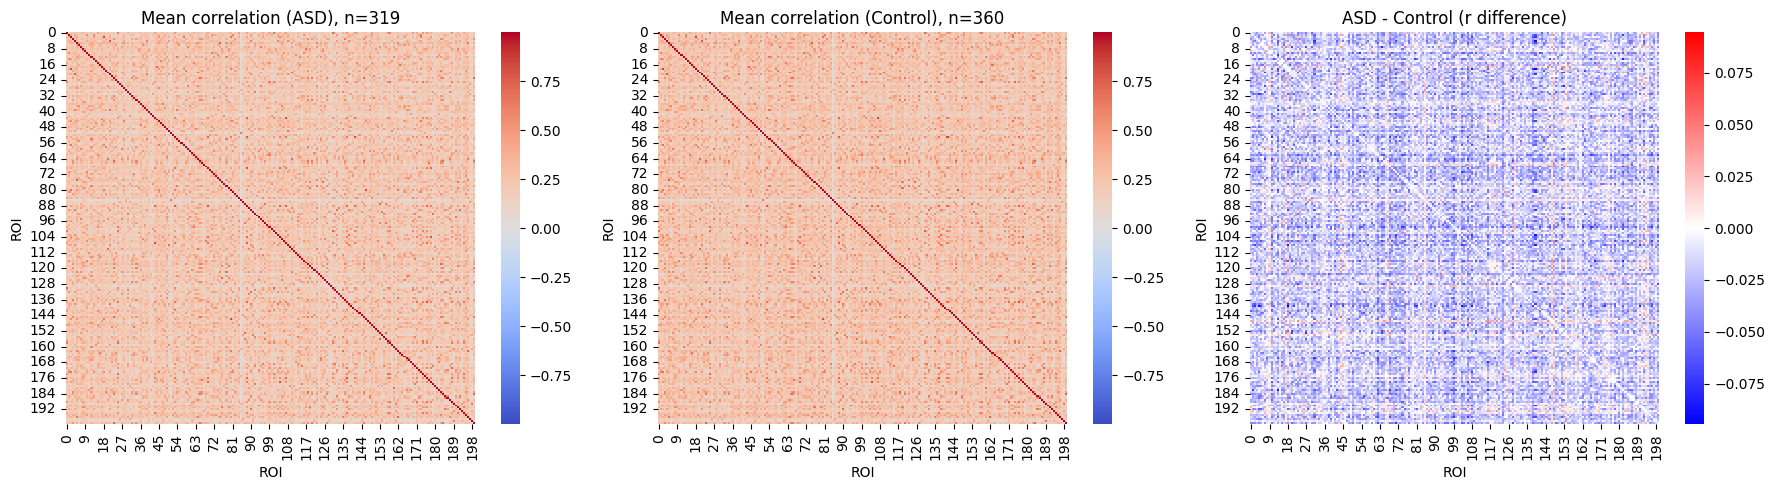

In [5]:
# --- Compute and plot group mean connectivity matrices ---
# compute mean Z matrices (if accumulation performed)
if sumZ_asd is not None and count_asd>0:
    meanZ_asd = sumZ_asd / count_asd
else:
    meanZ_asd = np.zeros((R,R))
if sumZ_tdc is not None and count_tdc>0:
    meanZ_tdc = sumZ_tdc / count_tdc
else:
    meanZ_tdc = np.zeros((R,R))

# convert meanZ -> meanR (correlation space)
meanR_asd = np.tanh(meanZ_asd)
meanR_tdc = np.tanh(meanZ_tdc)
diffR = meanR_asd - meanR_tdc

# Plot heatmaps (aesthetics)
plt.figure(figsize=(18, 5))
vmax = max(np.abs(meanR_asd).max(), np.abs(meanR_tdc).max())
# ASD
plt.subplot(1,3,1)
sns.heatmap(meanR_asd, cmap="coolwarm", center=0, cbar=True, vmax=vmax, vmin=-vmax)
plt.title(f"Mean correlation (ASD), n={count_asd}")
plt.xlabel("ROI"); plt.ylabel("ROI")
# Control
plt.subplot(1,3,2)
sns.heatmap(meanR_tdc, cmap="coolwarm", center=0, cbar=True, vmax=vmax, vmin=-vmax)
plt.title(f"Mean correlation (Control), n={count_tdc}")
plt.xlabel("ROI"); plt.ylabel("ROI")
# Difference
plt.subplot(1,3,3)
# center colorbar at zero for difference
maxdiff = np.abs(diffR).max()
sns.heatmap(diffR, cmap="bwr", center=0, cbar=True, vmax=maxdiff, vmin=-maxdiff)
plt.title("ASD - Control (r difference)")
plt.xlabel("ROI"); plt.ylabel("ROI")

plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, "mean_connectivity_heatmaps.png"), dpi=200)
print("Saved heatmaps to mean_connectivity_heatmaps.png")

Number of sites (groups): 24
LOSO mean accuracy = 0.7001 (std 0.1505), aggregated AUC = 0.7379
Run time: 44.2s


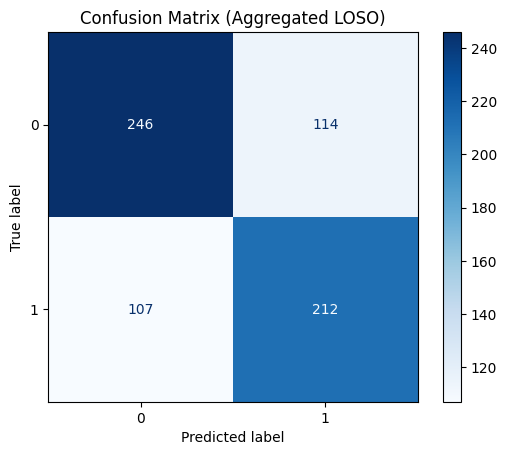

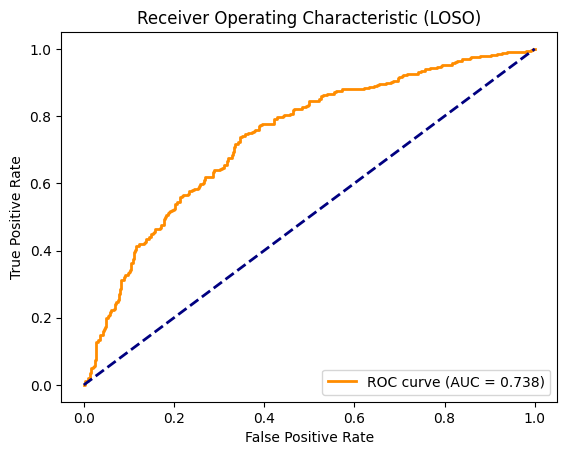

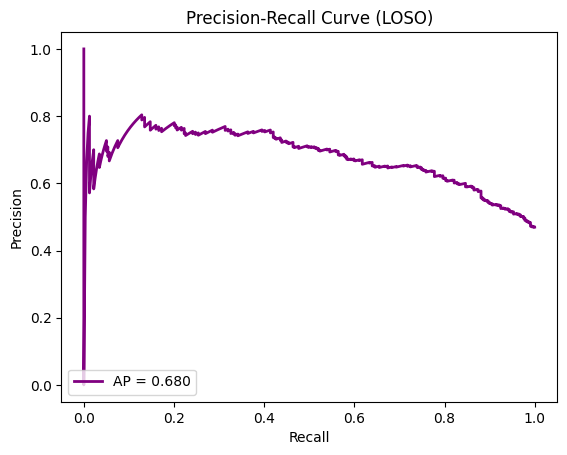

Classification Report:

              precision    recall  f1-score   support

           0      0.697     0.683     0.690       360
           1      0.650     0.665     0.657       319

    accuracy                          0.675       679
   macro avg      0.674     0.674     0.674       679
weighted avg      0.675     0.675     0.675       679



In [6]:
# --- LOSO with parallelization ---
logo = LeaveOneGroupOut()
unique_groups = np.unique(groups)
print("Number of sites (groups):", len(unique_groups))

def run_fold(train_idx, test_idx):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    clf = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            solver='liblinear',
            max_iter=2000,
            random_state=RANDOM_SEED))
    clf.fit(X_tr, y_tr)
    yhat = clf.predict(X_te)
    yhat_proba = clf.predict_proba(X_te)[:,1]
    acc = accuracy_score(y_te, yhat)
    coefs = clf.named_steps['logisticregression'].coef_[0]

    return acc, y_te.tolist(), yhat.tolist(), yhat_proba.tolist(), coefs.tolist()

start_time = time.time()

# Run LOSO
results = Parallel(n_jobs=-1)(
    delayed(run_fold)(train_idx, test_idx)
    for train_idx, test_idx in logo.split(X, y, groups))

# Aggregate metrics
fold_accuracies = [r[0] for r in results]
y_true_all = [y for r in results for y in r[1]]
y_pred_all = [y for r in results for y in r[2]]
y_pred_proba_all = [p for r in results for p in r[3]]

# Collect coefficients (average across folds)
coefs_all = np.array([r[4] for r in results])  # shape = (n_folds, n_features)
mean_coefs = coefs_all.mean(axis=0)

obs_acc = np.mean(fold_accuracies)
obs_auc = roc_auc_score(y_true_all, y_pred_proba_all)
print(f"LOSO mean accuracy = {obs_acc:.4f} (std {np.std(fold_accuracies):.4f}), aggregated AUC = {obs_auc:.4f}")
print(f"Run time: {time.time()-start_time:.1f}s")

# --- Confusion Matrix ---
cm = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Aggregated LOSO)")
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_true_all, y_pred_proba_all)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (LOSO)")
plt.legend(loc="lower right")
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_true_all, y_pred_proba_all)
avg_prec = average_precision_score(y_true_all, y_pred_proba_all)

plt.figure()
plt.plot(recall, precision, color="purple", lw=2, label=f"AP = {avg_prec:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LOSO)")
plt.legend(loc="lower left")
plt.show()

# --- Per-class Precision, Recall, F1 ---
print("Classification Report:\n")
print(classification_report(y_true_all, y_pred_all, digits=3))

19900
Atlas shape: (47, 56, 46, 43)
Volume 0: 10 labels
Volume 1: 20 labels
Volume 2: 30 labels
Volume 3: 40 labels
Volume 4: 50 labels
Volume 5: 60 labels
Volume 6: 70 labels
Volume 7: 80 labels
Volume 8: 90 labels
Volume 9: 100 labels
Volume 10: 110 labels
Volume 11: 120 labels
Volume 12: 129 labels
Volume 13: 140 labels
Volume 14: 150 labels
Volume 15: 160 labels
Volume 16: 169 labels
Volume 17: 180 labels
Volume 18: 190 labels
Selected volume 18 with 190 labels.
Number of ROI coordinates: 190
Coefficient matrix shape: (190, 190)


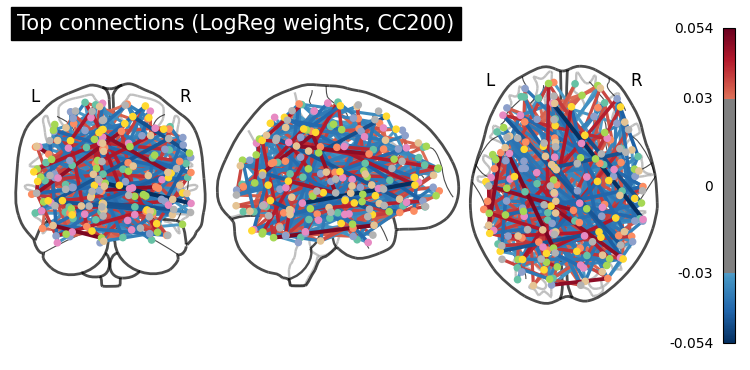

In [7]:
# Plot coefficients on brain map
print(X.shape[1])
atlas_img = nib.load("scorr05_2level_all.nii.gz")
print("Atlas shape:", atlas_img.shape)

# --- Find the correct slice (with ~200 unique labels) ---
n_vols = atlas_img.shape[3]
atlas_200 = None

for idx in range(n_vols):
    vol = image.index_img(atlas_img, idx)
    n_labels = len(np.unique(vol.get_fdata())) - 1  # subtract background (0)
    print(f"Volume {idx}: {n_labels} labels")
    if 190 <= n_labels <= 210:   # tolerance around 200
        atlas_200 = vol
        print(f"Selected volume {idx} with {n_labels} labels.")
        break

if atlas_200 is None:
    raise RuntimeError("Could not find a 200-ROI parcellation in atlas file.")

# --- Get ROI coordinates ---
coords = plotting.find_parcellation_cut_coords(atlas_200)
print("Number of ROI coordinates:", len(coords))

# --- Build connectivity matrix from your coefficients ---
n_rois = len(coords)
coef_vector = mean_coefs  # your logistic regression weights (length ~19900)
coef_matrix = np.zeros((n_rois, n_rois))

idx = 0
for i in range(n_rois):
    for j in range(i+1, n_rois):
        coef_matrix[i, j] = coef_vector[idx]
        coef_matrix[j, i] = coef_vector[idx]
        idx += 1

print("Coefficient matrix shape:", coef_matrix.shape)

# --- Plot top connections ---
plotting.plot_connectome(coef_matrix, coords,
                         edge_threshold="98%",
                         title="Top connections (LogReg weights, CC200)",
                         node_size=20)
plotting.show()

In [8]:
# Permutation Test
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def run_one_permutation(seed):
    rng = np.random.RandomState(seed)
    y_perm = rng.permutation(y)
    fold_accs_perm = []
    for train_idx, test_idx in logo.split(X_scaled, y_perm, groups):
        X_tr, X_te = X_scaled[train_idx], X_scaled[test_idx]
        y_tr_perm, y_te_perm = y_perm[train_idx], y_perm[test_idx]
        clf = LogisticRegression(solver='lbfgs', max_iter=1000, n_jobs=-1)
        clf.fit(X_tr, y_tr_perm)
        yhat = clf.predict(X_te)
        fold_accs_perm.append(accuracy_score(y_te_perm, yhat))
    return np.mean(fold_accs_perm)

N_PERMS = 1000   
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
start_time = time.time()

perm_accs = Parallel(n_jobs=-1)(
    delayed(run_one_permutation)(RANDOM_SEED+i) for i in range(N_PERMS)
)
perm_accs = np.array(perm_accs)

p_value = (np.sum(perm_accs >= obs_acc) + 1) / (N_PERMS + 1)
print(f"Permutation test p-value = {p_value:.4f}")
print(f"Run time: {time.time()-start_time:.1f}s")

mean_null = perm_accs.mean()
std_null = perm_accs.std()
perc_95 = np.percentile(perm_accs, 95)
perc_99 = np.percentile(perm_accs, 99)

print(f"Null mean = {mean_null:.3f}, std = {std_null:.3f}")
print(f"95th percentile = {perc_95:.3f}, 99th percentile = {perc_99:.3f}")

z_score = (obs_acc - mean_null) / std_null
print(f"Observed z-score vs null = {z_score:.2f}")

results_df = pd.DataFrame({
    "obs_acc": [obs_acc],
    "p_value": [p_value],
    "null_mean": [mean_null],
    "null_std": [std_null],
    "z_score": [z_score],
    "perc_95": [perc_95],
    "perc_99": [perc_99]
})
results_df.to_csv(os.path.join(DATA_DIR, "permutation_summary.csv"), index=False)

Permutation test p-value = 0.0010
Run time: 20580.8s
Null mean = 0.493, std = 0.045
95th percentile = 0.566, 99th percentile = 0.592
Observed z-score vs null = 4.57


Saved permutation histogram to permutation_histogram.png
All done.


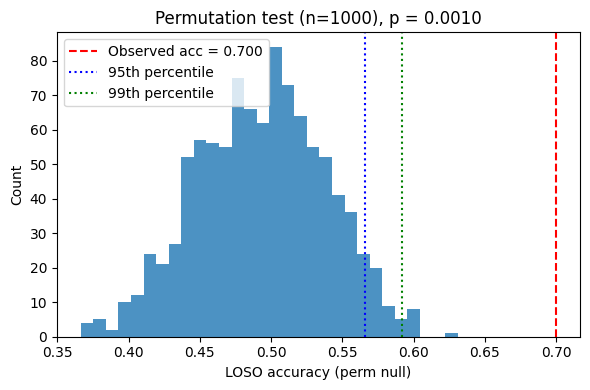

In [9]:
# --- Plot permutation histogram with observed accuracy ---
plt.figure(figsize=(6,4))
plt.hist(perm_accs, bins=30, alpha=0.8)
plt.axvline(obs_acc, color='red', linestyle='--', label=f"Observed acc = {obs_acc:.3f}")
plt.axvline(perc_95, color="blue", linestyle=":", label="95th percentile")
plt.axvline(perc_99, color="green", linestyle=":", label="99th percentile")
plt.xlabel("LOSO accuracy (perm null)")
plt.ylabel("Count")
plt.title(f"Permutation test (n={N_PERMS}), p = {p_value:.4f}")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, "permutation_histogram.png"), dpi=200)
print("Saved permutation histogram to permutation_histogram.png")

# --- Save numerical outputs for later reporting ---
np.save(os.path.join(DATA_DIR, "X_fc_cc200.npy"), X)
np.save(os.path.join(DATA_DIR, "y_fc_cc200.npy"), y)
np.save(os.path.join(DATA_DIR, "groups_fc_cc200.npy"), groups)
np.save(os.path.join(DATA_DIR, "perm_accs.npy"), perm_accs)

print("All done.")